# Import Libraries

In [1]:
import torch
print(torch.__version__)
import torchvision
import torch.nn as nn

import os
import sys
import time

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

1.8.1


# GPU/CUDA setup

In [2]:
if torch.cuda.is_available():
    print("CUDA enabled!")
device = 'cuda:0'
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(f'{i}' for i in range(1))

CUDA enabled!


# Autoencoder Helpers

In [3]:
"""
Adopted from @author Oscar Li

Source: https://github.com/OscarcarLi/PrototypeDL
"""
def makedirs(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

def list_of_distances(X, Y):
    '''
    Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
    Y = [y_1, ... , y_m], we return a list of vectors
            [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
             ...
             [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
    where the distance metric used is the sqared euclidean distance.
    The computation is achieved through a clever use of broadcasting.
    '''
    XX = torch.reshape(list_of_norms(X), shape=(-1, 1))

    YY = torch.reshape(list_of_norms(Y), shape=(1, -1))
    output = XX + YY - 2 * torch.matmul(X, torch.transpose(Y, 0, 1))
    return output

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return torch.sum(torch.pow(X, 2),dim=1)

def print_and_write(str, file):
    '''
    print str to the console and also write it to file
    '''
    print(str)
    file.write(str + '\n')



# Network Modules

In [4]:
class EncoderLayer(nn.Module):
    def __init__(self, in_channels=1, n_maps=32, out_channels=10, n_layers=4):
        super(EncoderLayer, self).__init__()
        
        el = []
        el += [ConvLayer(in_channels, n_maps, stride=2, padding=1)]
        for i in range(0, n_layers-2):
            el += [ConvLayer(n_maps, n_maps, stride=2, padding=1)]   
        el += [ConvLayer(n_maps, out_channels, stride=2, padding=1)]

        self.encoder = nn.Sequential(*el)

    def forward(self, x):
        return self.encoder(x)

class DecoderLayer(nn.Module):
    def __init__(self, in_channels=10, n_maps=32, out_channels=1, out_shapes=[], n_layers=4):
        super(DecoderLayer, self).__init__()

        dl = []
        dl += [DeConvLayer(in_channels, n_maps, out_shape=out_shapes[-1], stride=2, padding=1, output_padding=1)]
        for i in range(1, n_layers-1):
            dl += [DeConvLayer(n_maps, n_maps, out_shape=out_shapes[-(i+1)], stride=2, padding=1, output_padding=1)]
        dl += [DeConvLayer(n_maps, out_channels, out_shape=out_shapes[-n_layers], stride=2, padding=1, 
                           output_padding=1, activation=nn.Sigmoid)]

        self.decoder = nn.Sequential(*dl)

    def forward(self, x):
        return self.decoder(x)

class PrototypeLayer(nn.Module):
    def __init__(self, in_channels=10, n_prototypes=15):
        super(PrototypeLayer, self).__init__()

        self.prototype_distances = torch.rand(n_prototypes, in_channels, requires_grad=True).to(device)

    def forward(self, x):
        return list_of_distances(x, self.prototype_distances)

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, padding=1, activation=nn.ReLU):
        super(ConvLayer, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3,
                             stride=stride, padding=padding)
        self.activation = activation()

    def forward(self, x):
        self.in_dim = x.shape[-2:]
        return self.activation(self.conv(x)) 

class DeConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, out_shape, stride=2, padding=1, output_padding=1, activation=nn.ReLU):
        super(DeConvLayer, self).__init__()
        self.out_shape = out_shape
        self.dconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, 
                                        stride=stride, padding=padding, output_padding=output_padding)
        self.activation = activation()

    def forward(self, x):
        out_convt = self.dconv(x)
        if (out_convt.shape[-2:][0] != self.out_shape[0]) & (out_convt.shape[-2:][1] != self.out_shape[1]):
            out_convt = out_convt[:,:,(out_convt.shape[-2:][0] - self.out_shape[0]):,
                                 (out_convt.shape[-2:][1] - self.out_shape[1]):]
        return self.activation(out_convt)

class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features=15, out_features=10):
        super(FullyConnectedLayer, self).__init__()

        self.linear = nn.Linear(in_features=in_features, out_features=out_features)

    def forward(self, x):
        return self.linear(x)

class Softmax(nn.Module):
    def __init__(self):
        super(Softmax, self).__init__()

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(x)

# CAE Model definition

In [5]:
class CAEModel(nn.Module):
    def __init__(self, input_shape=(1, 1, 28,28), n_maps=32, n_prototypes=15, n_layers=4, n_classes=10):
        super(CAEModel, self).__init__()

        # add encoder layer
        self.encoder = EncoderLayer(in_channels=input_shape[1], n_maps=n_maps, out_channels=n_classes, n_layers=n_layers)
        
        # add prototype layer
        self.in_channels_prototype = self.encoder.forward(torch.randn(input_shape)).view(-1,1).shape[0]
        self.prototype_layer = PrototypeLayer(in_channels=self.in_channels_prototype, n_prototypes=n_prototypes)

        # add decoder layer
        decoder_out_shapes = []
        for layer in self.encoder.modules():
            if isinstance(layer, ConvLayer):
                decoder_out_shapes += [list(layer.in_dim)]
        self.decoder = DecoderLayer(in_channels=n_classes, n_maps=n_maps, out_channels=input_shape[1], out_shapes=decoder_out_shapes)
        
        # output layer
        # add final fully connected layer
        self.fc = FullyConnectedLayer(in_features=n_prototypes, out_features=n_classes)
        self.feature_vectors = None

    def forward(self, x):
        encoder_out = self.encoder(x)
        self.feature_vectors = encoder_out
        prototype_out = self.prototype_layer(encoder_out.view(-1,self.in_channels_prototype))
        fc_out = self.fc(prototype_out)
        return fc_out

# Data Processing

In [6]:
"""
Adopted from @author Oscar Li

Source: https://github.com/OscarcarLi/PrototypeDL
"""
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def batch_elastic_transform(images, sigma, alpha, height, width, random_state=None):
    '''
    this code is borrowed from chsasank on GitHubGist
    Elastic deformation of images as described in [Simard 2003].
    
    images: a two-dimensional numpy array; we can think of it as a list of flattened images
    sigma: the real-valued variance of the gaussian kernel
    alpha: a real-value that is multiplied onto the displacement fields
    
    returns: an elastically distorted image of the same shape
    '''
    assert len(images.shape) == 2
    # the two lines below ensure we do not alter the array images
    e_images = np.empty_like(images)
    e_images[:] = images
    
    e_images = e_images.reshape(-1, height, width)
    
    if random_state is None:
        random_state = np.random.RandomState(None)
    x, y = np.mgrid[0:height, 0:width]
    
    for i in range(e_images.shape[0]):
        
        dx = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        dy = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        indices = x + dx, y + dy
        e_images[i] = map_coordinates(e_images[i], indices, order=1)

    return e_images.reshape(-1, height*width)

# MINIST Data Loader

In [7]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# function to load and return train and val multi-process iterator over the MNIST dataset.

def get_train_val_loader(data_dir, batch_size, random_seed, augment=False, val_size=0.2, 
                         shuffle=True, show_sample=False, num_workers=0, pin_memory=True):

    # load the dataset
    train_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=transforms.ToTensor())
    val_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=transforms.ToTensor())

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(val_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # create data iterator
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, 
                                               num_workers=num_workers, pin_memory=pin_memory)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, 
                                             num_workers=num_workers, pin_memory=pin_memory)
    return (train_loader, val_loader)

# function to load and return a multi-process test iterator over the MNIST dataset.
def get_test_loader(data_dir, 
                    batch_size,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True):

    dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, 
                                              num_workers=num_workers, pin_memory=pin_memory)
    return data_loader

# The directory to save the model

In [8]:
model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model", "mnist_cae_1")
makedirs(model_folder)
img_folder = os.path.join(model_folder, "img")
makedirs(img_folder)
model_filename = "mnist_cae"

# console_log is the handle to a text file that records the console output
log_folder=os.path.join(model_folder, "log")
makedirs(log_folder)
console_log = open(os.path.join(log_folder, "console_log.txt"), "w+")

# Model parameters

In [9]:
# training parameters
learning_rate = 0.002
training_epochs = 100 #1500
batch_size = 250              # the size of a minibatch
test_display_step = 100       # how many epochs we do evaluate on the test set once
save_step = 5                # how frequently do we save the model to disk

# elastic deformation parameters
sigma = 4
alpha =20

# lambda's are the ratios between the four error terms
lambda_class = 20
lambda_ae = 1
lambda_1 = 1            # 1 and 2 here corresponds to the notation we used in the paper
lambda_2 = 1

# input data parameters
input_height = 28         # MNIST data input shape
input_width = input_height
n_input_channel = 1       # the number of color channels; for MNIST is 1.
input_size = input_height * input_width * n_input_channel   # the number of pixels in one input image
input_shape = (1, n_input_channel, input_height, input_height) # input shape to pass in the model
n_classes = 10

# Network Parameters
n_prototypes = 15         # the number of prototypes
n_layers = 4
n_maps = 32

# Load MNIST Data

In [10]:
#you may need to install the following packages in your python environment if it fails to donload data.
#conda install -c conda-forge ipywidgets
#jupyter nbextension enable --py widgetsnbextension
# the following two for jupyter hosted environment
#conda install -n base -c conda-forge widgetsnbextension
#conda install -n <your_environment_name> -c conda-forge ipywidgets


In [11]:
# data load and split parameters
random_seed = 1
n_workers = 0
data_folder = 'data'

# download MNIST data
train_loader, val_loader = get_train_val_loader(data_folder, batch_size, random_seed, augment=False, val_size=0.2,
                           shuffle=True, show_sample=False, num_workers=0, pin_memory=True)
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=0, pin_memory=True)

C:\Users\mosta\.conda\envs\torchenv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Get the CAE model

In [12]:
model = CAEModel(input_shape=input_shape, n_maps=n_maps, n_prototypes=n_prototypes, 
                 n_layers=n_layers, n_classes=n_classes).to(device)

# Optimizer setup

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model on MNIST data

################################################################################
Epoch: 0001/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:32<00:00,  5.91it/s]
training set errors:	classification error: 1.139625	autoencoder error: 0.047213	error_1: 2.588017	error_2: 3.184385	total error: 28.612110	accuracy: 0.319438
training takes 32.49 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 21.01it/s]
validation set errors:	classification error: 0.913494	autoencoder error: 0.057835	error_1: 2.548444	error_2: 3.704017	total error: 24.580168	accuracy: 0.759417
################################################################################
Epoch: 0002/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:31<00:00,  6.06it/s]
training set errors:	classification error: 0.508373	autoencoder error: 0.042264	error_1: 2.27869

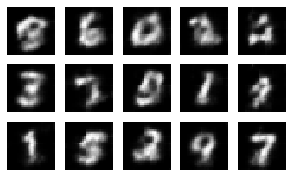

Visualizing encoded and decoded images:


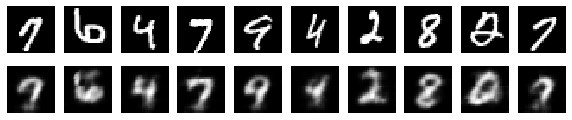

################################################################################
Epoch: 0006/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.21it/s]
training set errors:	classification error: 0.218514	autoencoder error: 0.038211	error_1: 1.347650	error_2: 2.069410	total error: 7.825554	accuracy: 0.945209
training takes 26.62 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 26.23it/s]
validation set errors:	classification error: 0.117103	autoencoder error: 0.045667	error_1: 1.350604	error_2: 2.134102	total error: 5.872438	accuracy: 0.968250
################################################################################
Epoch: 0007/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.13it/s]
training set errors:	classification error: 0.164059	autoencoder error: 0.038711	error_1: 1.008830	

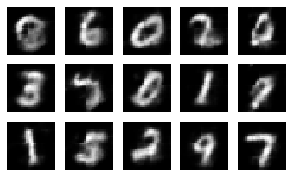

Visualizing encoded and decoded images:


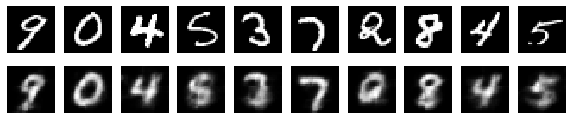

################################################################################
Epoch: 0011/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:25<00:00,  7.54it/s]
training set errors:	classification error: 0.141897	autoencoder error: 0.038720	error_1: 0.883507	error_2: 1.719959	total error: 5.480131	accuracy: 0.961125
training takes 25.48 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.45it/s]
validation set errors:	classification error: 0.064362	autoencoder error: 0.044506	error_1: 0.695219	error_2: 1.660853	total error: 3.687821	accuracy: 0.976667
################################################################################
Epoch: 0012/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:25<00:00,  7.41it/s]
training set errors:	classification error: 0.160604	autoencoder error: 0.037331	error_1: 0.870497	

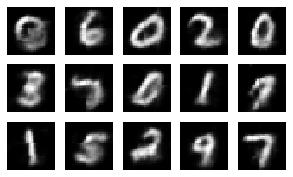

Visualizing encoded and decoded images:


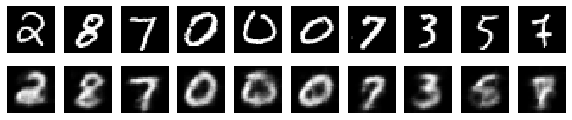

################################################################################
Epoch: 0016/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.30it/s]
training set errors:	classification error: 0.121394	autoencoder error: 0.038104	error_1: 0.667499	error_2: 1.607484	total error: 4.740977	accuracy: 0.967792
training takes 26.32 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 26.41it/s]
validation set errors:	classification error: 0.079027	autoencoder error: 0.044035	error_1: 0.651231	error_2: 1.548913	total error: 3.824719	accuracy: 0.978750
################################################################################
Epoch: 0017/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:25<00:00,  7.60it/s]
training set errors:	classification error: 0.086506	autoencoder error: 0.036934	error_1: 0.595833	

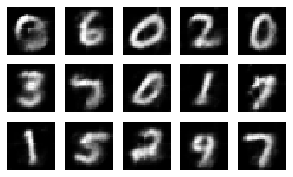

Visualizing encoded and decoded images:


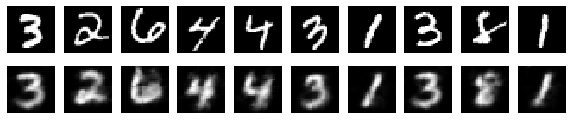

################################################################################
Epoch: 0021/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:25<00:00,  7.51it/s]
training set errors:	classification error: 0.069061	autoencoder error: 0.038433	error_1: 0.566044	error_2: 1.385517	total error: 3.371221	accuracy: 0.971708
training takes 25.58 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 26.19it/s]
validation set errors:	classification error: 0.040919	autoencoder error: 0.042795	error_1: 0.539627	error_2: 1.474241	total error: 2.875052	accuracy: 0.980333
################################################################################
Epoch: 0022/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:25<00:00,  7.60it/s]
training set errors:	classification error: 0.123948	autoencoder error: 0.036748	error_1: 0.684514	

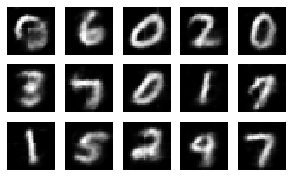

Visualizing encoded and decoded images:


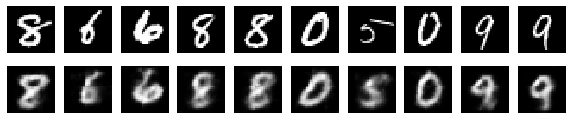

################################################################################
Epoch: 0026/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.33it/s]
training set errors:	classification error: 0.054855	autoencoder error: 0.038716	error_1: 0.562102	error_2: 1.335466	total error: 3.033391	accuracy: 0.973667
training takes 26.18 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 21.91it/s]
validation set errors:	classification error: 0.046104	autoencoder error: 0.042902	error_1: 0.510458	error_2: 1.256516	total error: 2.731952	accuracy: 0.983917
################################################################################
Epoch: 0027/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:27<00:00,  6.96it/s]
training set errors:	classification error: 0.082162	autoencoder error: 0.038967	error_1: 0.590688	

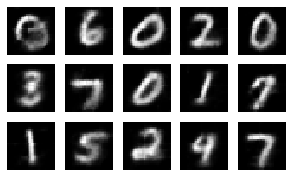

Visualizing encoded and decoded images:


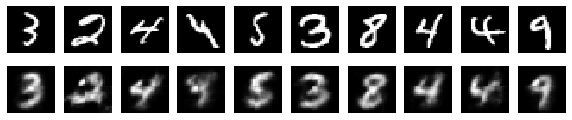

################################################################################
Epoch: 0031/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.32it/s]
training set errors:	classification error: 0.055841	autoencoder error: 0.038004	error_1: 0.467652	error_2: 1.322209	total error: 2.944674	accuracy: 0.975979
training takes 26.25 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 24.70it/s]
validation set errors:	classification error: 0.031772	autoencoder error: 0.043332	error_1: 0.625435	error_2: 1.234083	total error: 2.538292	accuracy: 0.983333
################################################################################
Epoch: 0032/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.22it/s]
training set errors:	classification error: 0.086051	autoencoder error: 0.038670	error_1: 0.465765	

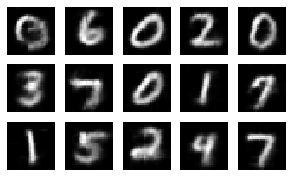

Visualizing encoded and decoded images:


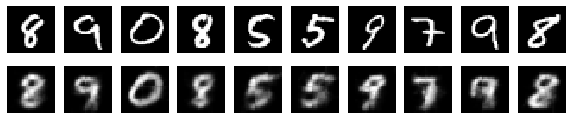

################################################################################
Epoch: 0036/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.25it/s]
training set errors:	classification error: 0.089748	autoencoder error: 0.038568	error_1: 0.408608	error_2: 1.305498	total error: 3.547637	accuracy: 0.977979
training takes 26.50 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 24.07it/s]
validation set errors:	classification error: 0.078326	autoencoder error: 0.043343	error_1: 0.483913	error_2: 1.221136	total error: 3.314911	accuracy: 0.981917
################################################################################
Epoch: 0037/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:27<00:00,  7.06it/s]
training set errors:	classification error: 0.075532	autoencoder error: 0.035799	error_1: 0.492060	

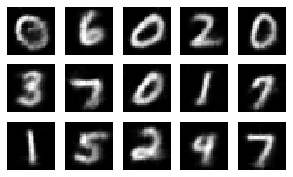

Visualizing encoded and decoded images:


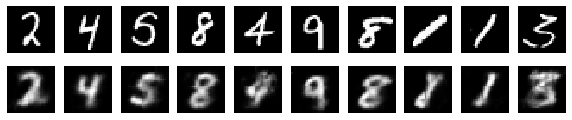

################################################################################
Epoch: 0041/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:27<00:00,  7.07it/s]
training set errors:	classification error: 0.109342	autoencoder error: 0.038426	error_1: 0.462113	error_2: 1.258638	total error: 3.946010	accuracy: 0.978479
training takes 27.17 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.76it/s]
validation set errors:	classification error: 0.056335	autoencoder error: 0.043079	error_1: 0.466566	error_2: 1.106779	total error: 2.743121	accuracy: 0.984584
################################################################################
Epoch: 0042/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.36it/s]
training set errors:	classification error: 0.177390	autoencoder error: 0.038669	error_1: 0.383228	

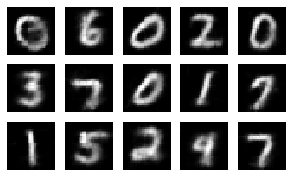

Visualizing encoded and decoded images:


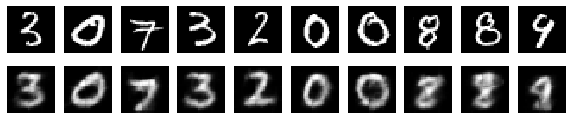

################################################################################
Epoch: 0046/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.24it/s]
training set errors:	classification error: 0.061026	autoencoder error: 0.036059	error_1: 0.389872	error_2: 1.116433	total error: 2.762889	accuracy: 0.979375
training takes 26.52 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 24.53it/s]
validation set errors:	classification error: 0.032758	autoencoder error: 0.042614	error_1: 0.396621	error_2: 1.078835	total error: 2.173237	accuracy: 0.983250
################################################################################
Epoch: 0047/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.22it/s]
training set errors:	classification error: 0.033507	autoencoder error: 0.036519	error_1: 0.327497	

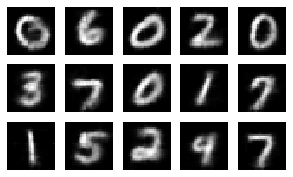

Visualizing encoded and decoded images:


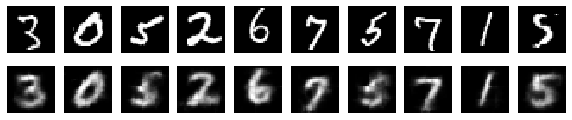

################################################################################
Epoch: 0051/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:27<00:00,  7.09it/s]
training set errors:	classification error: 0.081316	autoencoder error: 0.038466	error_1: 0.505431	error_2: 1.186707	total error: 3.356932	accuracy: 0.979041
training takes 27.10 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 24.09it/s]
validation set errors:	classification error: 0.050885	autoencoder error: 0.043176	error_1: 0.313147	error_2: 1.045844	total error: 2.419868	accuracy: 0.985500
################################################################################
Epoch: 0052/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.29it/s]
training set errors:	classification error: 0.083993	autoencoder error: 0.037574	error_1: 0.331880	

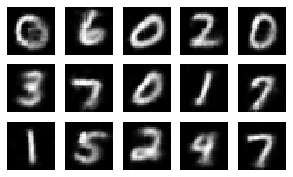

Visualizing encoded and decoded images:


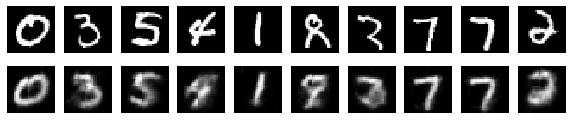

################################################################################
Epoch: 0056/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.23it/s]
training set errors:	classification error: 0.036524	autoencoder error: 0.036752	error_1: 0.398603	error_2: 1.055471	total error: 2.221310	accuracy: 0.979562
training takes 26.57 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 24.04it/s]
validation set errors:	classification error: 0.023913	autoencoder error: 0.042133	error_1: 0.303126	error_2: 0.997342	total error: 1.820871	accuracy: 0.986333
################################################################################
Epoch: 0057/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.32it/s]
training set errors:	classification error: 0.062025	autoencoder error: 0.037944	error_1: 0.374602	

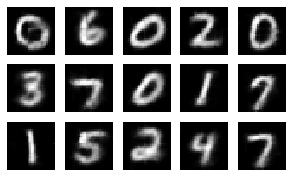

Visualizing encoded and decoded images:


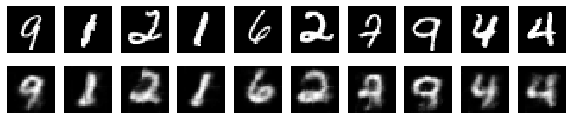

################################################################################
Epoch: 0061/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.18it/s]
training set errors:	classification error: 0.060780	autoencoder error: 0.035167	error_1: 0.341796	error_2: 1.105131	total error: 2.697694	accuracy: 0.980146
training takes 26.74 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 24.60it/s]
validation set errors:	classification error: 0.097153	autoencoder error: 0.042724	error_1: 0.325452	error_2: 1.064808	total error: 3.376046	accuracy: 0.987083
################################################################################
Epoch: 0062/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:27<00:00,  6.91it/s]
training set errors:	classification error: 0.052303	autoencoder error: 0.036476	error_1: 0.396366	

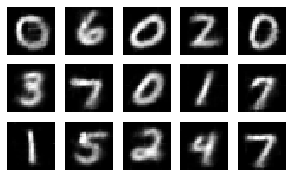

Visualizing encoded and decoded images:


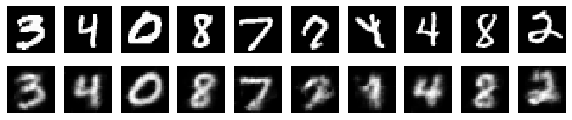

################################################################################
Epoch: 0066/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.19it/s]
training set errors:	classification error: 0.054235	autoencoder error: 0.037271	error_1: 0.266034	error_2: 1.077575	total error: 2.465580	accuracy: 0.980938
training takes 26.72 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.00it/s]
validation set errors:	classification error: 0.026882	autoencoder error: 0.043628	error_1: 0.480517	error_2: 1.009910	total error: 2.071699	accuracy: 0.984667
################################################################################
Epoch: 0067/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.25it/s]
training set errors:	classification error: 0.076523	autoencoder error: 0.038238	error_1: 0.314225	

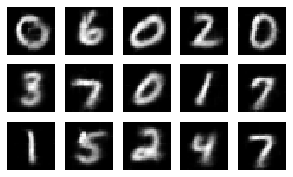

Visualizing encoded and decoded images:


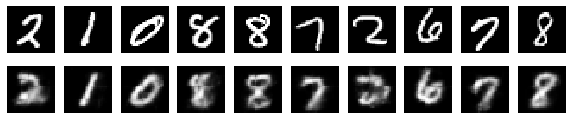

################################################################################
Epoch: 0071/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.26it/s]
training set errors:	classification error: 0.040093	autoencoder error: 0.036234	error_1: 0.319230	error_2: 1.036195	total error: 2.193527	accuracy: 0.981271
training takes 26.45 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.66it/s]
validation set errors:	classification error: 0.039295	autoencoder error: 0.042520	error_1: 0.250438	error_2: 0.929465	total error: 2.008327	accuracy: 0.987583
################################################################################
Epoch: 0072/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.31it/s]
training set errors:	classification error: 0.058767	autoencoder error: 0.038199	error_1: 0.246323	

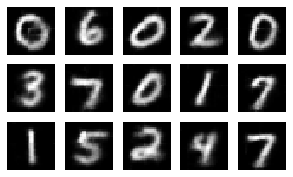

Visualizing encoded and decoded images:


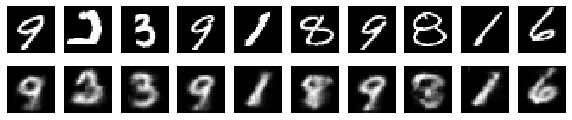

################################################################################
Epoch: 0076/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.15it/s]
training set errors:	classification error: 0.082893	autoencoder error: 0.036931	error_1: 0.223273	error_2: 1.042969	total error: 2.961025	accuracy: 0.982083
training takes 26.87 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 24.63it/s]
validation set errors:	classification error: 0.055874	autoencoder error: 0.042580	error_1: 0.252707	error_2: 0.935169	total error: 2.347946	accuracy: 0.987000
################################################################################
Epoch: 0077/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.25it/s]
training set errors:	classification error: 0.023762	autoencoder error: 0.035801	error_1: 0.276899	

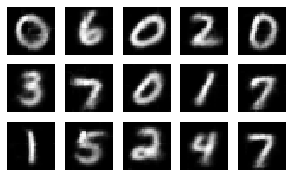

Visualizing encoded and decoded images:


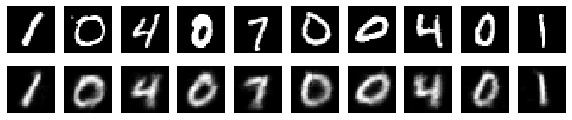

################################################################################
Epoch: 0081/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.27it/s]
training set errors:	classification error: 0.073777	autoencoder error: 0.037355	error_1: 0.295271	error_2: 0.959039	total error: 2.767200	accuracy: 0.980917
training takes 26.41 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 24.81it/s]
validation set errors:	classification error: 0.057177	autoencoder error: 0.042872	error_1: 0.269844	error_2: 0.938015	total error: 2.394271	accuracy: 0.987083
################################################################################
Epoch: 0082/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.27it/s]
training set errors:	classification error: 0.031372	autoencoder error: 0.036599	error_1: 0.320446	

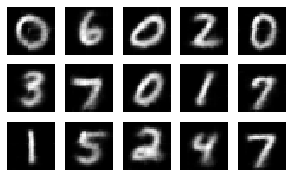

Visualizing encoded and decoded images:


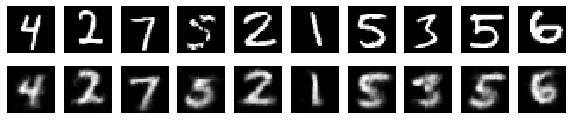

################################################################################
Epoch: 0086/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.29it/s]
training set errors:	classification error: 0.041453	autoencoder error: 0.037226	error_1: 0.323940	error_2: 0.962665	total error: 2.152893	accuracy: 0.981291
training takes 26.34 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.91it/s]
validation set errors:	classification error: 0.043931	autoencoder error: 0.041861	error_1: 0.227824	error_2: 0.900801	total error: 2.049102	accuracy: 0.986583
################################################################################
Epoch: 0087/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.14it/s]
training set errors:	classification error: 0.039854	autoencoder error: 0.038375	error_1: 0.246532	

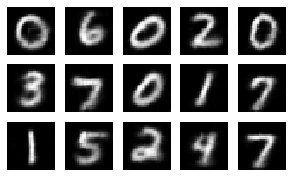

Visualizing encoded and decoded images:


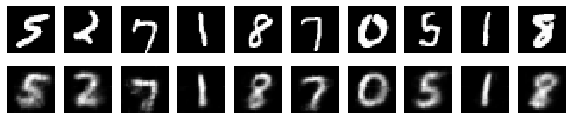

################################################################################
Epoch: 0091/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.34it/s]
training set errors:	classification error: 0.027628	autoencoder error: 0.037552	error_1: 0.228653	error_2: 0.956832	total error: 1.775591	accuracy: 0.981792
training takes 26.18 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 24.77it/s]
validation set errors:	classification error: 0.031384	autoencoder error: 0.042801	error_1: 0.209802	error_2: 0.822561	total error: 1.702846	accuracy: 0.986750
################################################################################
Epoch: 0092/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.12it/s]
training set errors:	classification error: 0.071382	autoencoder error: 0.037837	error_1: 0.194454	

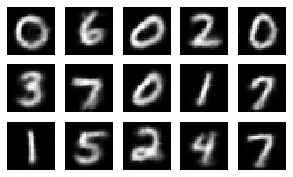

Visualizing encoded and decoded images:


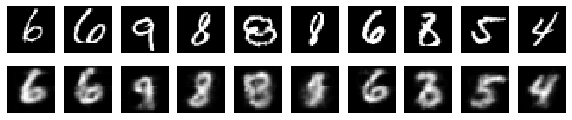

################################################################################
Epoch: 0096/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.33it/s]
training set errors:	classification error: 0.031315	autoencoder error: 0.036611	error_1: 0.214773	error_2: 0.939227	total error: 1.816914	accuracy: 0.982604
training takes 26.21 seconds.
batch: 048: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.92it/s]
validation set errors:	classification error: 0.023575	autoencoder error: 0.042218	error_1: 0.239223	error_2: 0.838036	total error: 1.590983	accuracy: 0.986917
################################################################################
Epoch: 0097/0100
batch: 192: 100%|████████████████████████████████████████████████████████████████████| 192/192 [00:26<00:00,  7.35it/s]
training set errors:	classification error: 0.043933	autoencoder error: 0.036459	error_1: 0.220878	

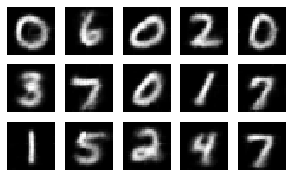

Visualizing encoded and decoded images:


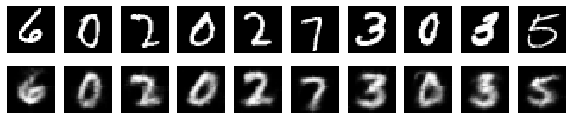

Total taken time 2899.52 seconds.
Optimization Finished!


In [14]:
from tqdm import tqdm, tqdm_notebook

start_time= time.time()

# train the model
for epoch in range(0, training_epochs):
    print_and_write("#"*80, console_log)
    print_and_write("Epoch: %04d" % (epoch+1)+"/%04d" % (training_epochs), console_log)
    n_train_batch = len(train_loader)
    n_val_batch = len(val_loader)
    n_test_batch = len(test_loader)
    start = time.time()

    train_ce, train_ae, train_e1, train_e2, train_te, train_ac = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    
    with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
        for i, batch in enumerate(train_loader):
            batch_x = batch[0]
            batch_y = batch[1]

            # store original batch shape to put it back into this shape after transformation
            batch_shape = batch_x.shape

            # apply elastic transform
            elastic_batch_x = batch_elastic_transform(batch_x.view(batch_size, -1), sigma=sigma, alpha=alpha, height=input_height, width=input_width)
            elastic_batch_x = torch.reshape(torch.tensor(elastic_batch_x), batch_shape)
            elastic_batch_x = elastic_batch_x.to(device)

            batch_y = batch_y.to(device)

            optimizer.zero_grad()        

            pred_y = model.forward(elastic_batch_x)

            # softmax crossentropy loss
            loss_function = torch.nn.CrossEntropyLoss()
            train_ce = loss_function(pred_y, batch_y)

            prototype_distances = model.prototype_layer.prototype_distances
            feature_vectors = model.feature_vectors

            train_e1 = torch.mean(torch.min(list_of_distances(prototype_distances, feature_vectors.view(-1, model.in_channels_prototype)), dim=1)[0])
            train_e2 = torch.mean(torch.min(list_of_distances(feature_vectors.view(-1, model.in_channels_prototype ), prototype_distances), dim=1)[0])

            out_decoder = model.decoder(feature_vectors)
            train_ae = torch.mean(list_of_norms(out_decoder-elastic_batch_x))

            train_te = lambda_class * train_ce +\
                    lambda_1 * train_e1 +\
                    lambda_2 * train_e2 +\
                    lambda_ae * train_ae

            train_te.backward()

            optimizer.step()

            # train accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            train_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

            pbar.set_description('batch: %03d' % (1 + i))
            pbar.update(1)
    
    train_ac /= n_train_batch
    print_and_write("training set errors:"+"\tclassification error: {:.6f}".format(train_ce)+
                    "\tautoencoder error: {:.6f}".format(train_ae)+
                    "\terror_1: {:.6f}".format(train_e1)+
                    "\terror_2: {:.6f}".format(train_e2)+
                    "\ttotal error: {:.6f}".format(train_te)+
                    "\taccuracy: {:.6f}".format(train_ac), console_log)
    print_and_write('training takes {0:.2f} seconds.'.format((time.time() - start)), console_log)
     
    # validation set error terms evaluation
    val_ce, val_ae, val_e1, val_e2, val_te, val_ac = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    
    with tqdm(total=len(val_loader), file=sys.stdout) as pbar:
        for i, batch in enumerate(val_loader):
            batch_x = batch[0]
            batch_y = batch[1]
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            pred_y = model.forward(batch_x)

            loss_function = torch.nn.CrossEntropyLoss()
            val_ce = loss_function(pred_y, batch_y)

            prototype_distances = model.prototype_layer.prototype_distances
            feature_vectors = model.feature_vectors

            val_e1 = torch.mean(torch.min(list_of_distances(prototype_distances, feature_vectors.view(-1, model.in_channels_prototype)), dim=1)[0])
            val_e2 = torch.mean(torch.min(list_of_distances(feature_vectors.view(-1, model.in_channels_prototype ), prototype_distances), dim=1)[0])

            out_decoder = model.decoder(feature_vectors)
            val_ae = torch.mean(list_of_norms(out_decoder-batch_x))

            val_te = lambda_class * val_ce +\
                    lambda_1 * val_e1 +\
                    lambda_2 * val_e2 +\
                    lambda_ae * val_ae
            # validation accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            val_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

            pbar.set_description('batch: %03d' % (1 + i))
            pbar.update(1)
           
    val_ac /= n_val_batch
    # after every epoch, check the error terms on the entire training set
    print_and_write("validation set errors:"+"\tclassification error: {:.6f}".format(val_ce)+
                    "\tautoencoder error: {:.6f}".format(val_ae)+
                    "\terror_1: {:.6f}".format(val_e1)+
                    "\terror_2: {:.6f}".format(val_e2)+
                    "\ttotal error: {:.6f}".format(val_te)+
                    "\taccuracy: {:.6f}".format(val_ac), console_log)
    
    # test set accuracy evaluation
    if (epoch+1) % test_display_step == 0 or epoch == training_epochs - 1:
        test_ac = 0

        for i, batch in enumerate(test_loader):
            batch_x = batch[0]
            batch_y = batch[1]
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            pred_y = model.forward(batch_x)

            # test accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            test_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

        test_ac /= n_test_batch

        print_and_write("test set:", console_log)
        print_and_write("\taccuracy: {:.4f}".format(test_ac), console_log)

    if (epoch+1) % save_step == 0 or epoch == training_epochs - 1:
        # save model states
        model_state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch+1}
        torch.save(model_state, os.path.join(model_folder, model_filename+'%05d.pth' % (epoch+1)))

        # save outputs as images
        # decode prototype vectors
        prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()

        # visualize the prototype images
        print_and_write("Visualizing the prototype images:", console_log)
        n_cols = 5
        n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
        g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
        for i in range(n_rows):
            for j in range(n_cols):
                if i*n_cols + j < n_prototypes:
                    b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                    cmap='gray',
                                    interpolation='none')
                    b[i][j].axis('off')
                    
        plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch+1) + '.png'),
                    transparent=True, bbox_inches='tight', pad_inches=0)
        plt.show()

        plt.close()

        # apply encoding and decoding over a small subset of the training set
        print_and_write("Visualizing encoded and decoded images:", console_log)
        batch_x = []
        for batch in train_loader:
            batch_x = batch[0].to(device)
            break

        examples_to_show = 10
        
        encoded = model.encoder.forward(batch_x[:examples_to_show])
        decoded = model.decoder.forward(encoded)

        decoded = decoded.detach().cpu()
        imgs = batch_x.detach().cpu()

        # compare original images to their reconstructions
        f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
        for i in range(examples_to_show):
            a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
            a[0][i].axis('off')
            a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
            a[1][i].axis('off')
            
        plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
                    transparent=True,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.show()
        plt.close()
        
print_and_write('Total taken time {0:.2f} seconds.'.format((time.time() - start_time)), console_log)
print_and_write("Optimization Finished!", console_log)
console_log.close()

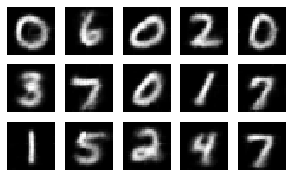

In [15]:
# save outputs as images
# decode prototype vectors
prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()
# visualize the prototype images
n_cols = 5
n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        if i*n_cols + j < n_prototypes:
            b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                    cmap='gray',
                                    interpolation='none')
            b[i][j].axis('off')                   
#plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch+1) + '.png'),
#                    transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

plt.close()

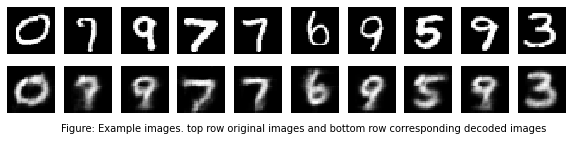

In [16]:
# apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    break

examples_to_show = 10
        
encoded = model.encoder.forward(batch_x[:examples_to_show])
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu()


# compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
    a[0][i].axis('off')
    a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
    a[1][i].axis('off')

f.text(.2,.005,'Figure: Example images. top row original images and bottom row corresponding decoded images')
#plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
#                    transparent=True,
#                    bbox_inches='tight',
#                    pad_inches=0)
plt.show()
plt.close()

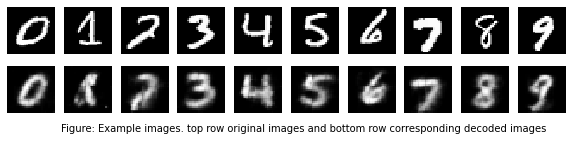

,0,1,2,3,4,5,6,7,8,9
0,11.636065,-1.223660,-7.031830,-3.480780,-4.179958,-4.452044,3.218521,-7.488886,-4.894398,-6.020638
1,-5.795304,9.205944,2.317938,-8.864089,1.467233,-11.673432,-7.880989,1.278681,-10.443020,0.672062
2,-5.633601,0.601740,6.529218,-0.294541,-6.288633,-8.616767,-9.228948,3.666874,-4.974387,-3.464240
3,-6.840447,-4.688042,-3.845247,10.904098,-12.659873,-1.718238,-10.076727,-3.196481,1.329437,-3.282325
4,-3.772051,-3.986145,-2.182780,-20.327795,14.929283,-9.761512,-2.521142,0.194176,-7.328671,5.835244
5,-1.956151,-9.229299,-9.043571,1.668781,-15.770399,15.191123,-0.635874,-5.825692,-3.741260,1.571606
6,-1.407035,-5.437314,-0.677186,-13.160179,-1.463966,0.623877,15.753184,-4.651636,3.206168,-10.840628
7,-6.447520,-1.876764,-0.958780,2.437262,-8.043987,-0.485206,-9.292474,7.391581,-10.782328,0.487140
8,-2.369650,-5.168681,-1.774421,-0.443456,-8.301111,-3.701497,-1.023942,-7.252740,9.816363,-5.003088
9,-7.009120,-5.108622,-8.142440,-4.074903,-0.598338,-4.470800,-10.991451,-0.321627,-0.027121,11.064942


In [21]:
import pandas as pd
# apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    batch_y = batch[1].to(device)
    break
    
pred_y = model.forward(batch_x)

pred_y_np = pred_y.detach().cpu().numpy() 
batch_y_np = batch_y.detach().cpu().numpy()
labels = []
data = []
idx = []
i = 0
j = 0
for l in batch_y_np:
    if(i==10):
        break
    if l==i:
        labels.append(l)
        data.append(pred_y_np[j])
        idx.append(j)
        i = i+1
    j = j + 1
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
examples_to_show = 10
        
encoded = model.encoder.forward(batch_x)
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu() 

# compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
j = 0
for i in idx:
    a[0][j].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
    a[0][j].axis('off')
    a[1][j].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
    a[1][j].axis('off')
    j = j + 1
            
#plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
#                    transparent=True,
#                    bbox_inches='tight',
#                    pad_inches=0)
f.text(.2,.005,'Figure: Example images. top row original images and bottom row corresponding decoded images')
plt.show()
plt.close()
    
df = pd.DataFrame(data, labels, classes)
df.style.format(precision=2)
df.style.highlight_max(props='background-color:red;color:white;', axis=1)


